In [2]:
# Import Statements

# Data Manipulation
import numpy as np
import pandas as pd
import glob
import os

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image Manipulation
from PIL import Image, ImageEnhance
import cv2

# Machine Learning

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load Train / Test Data
trainDataMRI = 'Dataset/Training/'
testDataMRI = 'Dataset/Testing/'
IMG_SIZE = 256

# Label Encoding
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
label_indexes = {label : i for i, label in enumerate(labels)}

# Empty Lists For Data
train_paths = []
train_labels = []
test_paths = []
test_labels = []

# Load Training Data
for label in labels:
    for img_file in glob.glob(trainDataMRI + f'/{label}/*.jpg'):
        img = cv2.imread(img_file, 0)  # This loads in grayscale. Remove ',0' for color.
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize if necessary
        img = img / 255.0  # Normalize pixel values
        train_paths.append(img)
        train_labels.append(label_indexes[label]) 

# Load Testing Data
for label in labels:
    for img_file in glob.glob(testDataMRI + f'/{label}/*.jpg'):
        img = cv2.imread(img_file, 0)  # This loads in grayscale. Remove ',0' for color.
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize if necessary
        img = img / 255.0  # Normalize pixel values
        test_paths.append(img)
        test_labels.append(label_indexes[label])  

# Coverting Lists To Numpy Arrays
trainPaths = np.array(train_paths)
trainLabels = np.array(train_labels)
testPaths = np.array(test_paths)
testLabels = np.array(test_labels)

# Resize Data (Linearize Images -> 1D Image Features Table, Row = Image)
trainPaths = trainPaths.reshape(trainPaths.shape[0], -1)
testPaths = testPaths.reshape(testPaths.shape[0], -1)

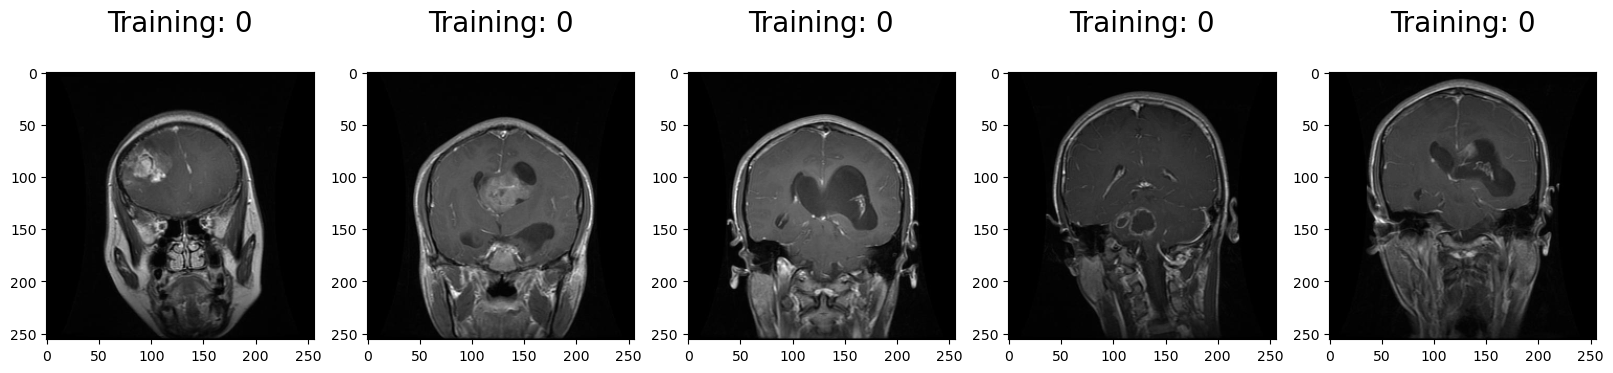

In [4]:
# Display Some Images From trainPaths
plt.figure(figsize=(20, 4))
for index, (image, label) in enumerate(zip(trainPaths[0:5], trainLabels[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (IMG_SIZE, IMG_SIZE)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)
plt.show()

### Data Reduction

[.5 points] Perform linear dimensionality reduction of the images using principal components analysis. Visualize the explained variance of each component. Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion.

Since images can be high-dimensional, linear dimensionality reduction techniques like Principal Components Analysis (PCA) can reduce the dimensionality of the image data. Reducing dimensionality makes computationally easier for further procesing and analysis.For example, reducing dimensionality helps make clustering, classification, and anomaly detection easier. 

Other applications of PCA for Machine Learning include reducing dimensionality and decorrelating features in order to improve the performance of machine learning algorithms by reducing the risk of overfitting and improving training time.

Let's take advantage of PCA and apply it to the brain MRI images. 

In [36]:
# Use full PCA for linearized image data
from sklearn.decomposition import PCA
aim_pca = PCA(svd_solver="full") # takes 16 minutes
aim_pca.fit(trainPaths)


Above, we performed PCA using all available components, allowing us choose a number of principal components based on the cumulative explained variance. While images should still be somewhat recognizable to human eyes, we can quantify the quality of the representation by aiming for a higher cumulative explained variance. A high cumulative explained variance indicates that a larger proportion of the data's variability was preserved after dimensionality reduction, which implies a better representation.

Let's get the cumulative explained variance. Let's also visualize the cumulative explained variance as we increase the number of principal components used.

Number of components explaining 95% variance: 1054
Number of components explaining 85% variance (shown): 322
Number of components explaining 70% variance: 97
Number of components explaining 50% variance (shown): 20


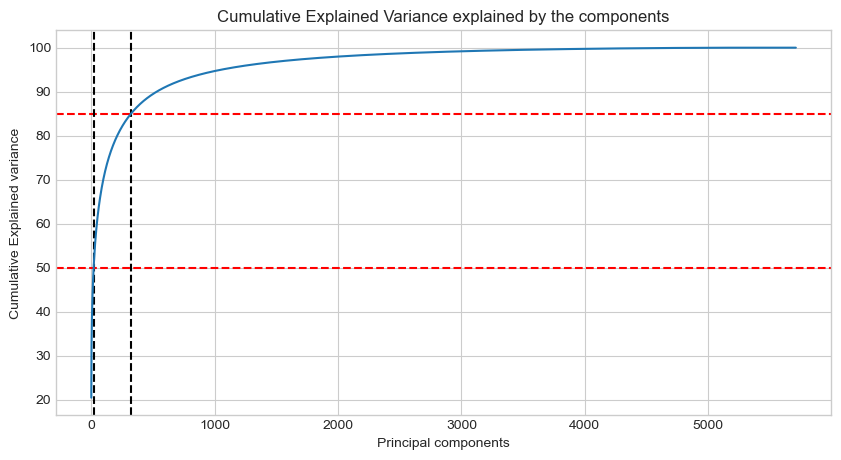

In [37]:
# Get cumulative variance
var_cumu = np.cumsum(aim_pca.explained_variance_ratio_)*100

# how many components explain 95% of the variance?
k95 = np.argmax(var_cumu > 95)
print("Number of components explaining 95% variance: "+ str(k95))

# how many components explain 85% of the variance?
k85 = np.argmax(var_cumu > 85)
print("Number of components explaining 85% variance (shown): "+ str(k85))

# how many components explain 70% of the variance?
k70 = np.argmax(var_cumu > 70)
print("Number of components explaining 70% variance: "+ str(k70))

# how many components explain 50% of the variance?
k50 = np.argmax(var_cumu > 50)
print("Number of components explaining 50% variance (shown): "+ str(k50))

plt.figure(figsize=[10,5])
plt.title('Cumulative Explained Variance explained by the components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axvline(x=k85, color="k", linestyle="--")
plt.axhline(y=85, color="r", linestyle="--")
plt.axvline(x=k50, color="k", linestyle="--")
plt.axhline(y=50, color="r", linestyle="--")
ax = plt.plot(var_cumu)

As shown in the Cumulative Explained Variance plot above, 95% cumulative explained variance can be achieved if we retain 1054 principal components. For the purposes of this project, 50% cumuluative explained variance can be achieved if we retain only 20 principal components. We will move forward retaining only 20 principal components.

To be more specific, we can visulize the first 50 principal components and their explained variance in a bar plot with the cumulative explained variance shown to be increasing with each additional component overlayed as a step plot.

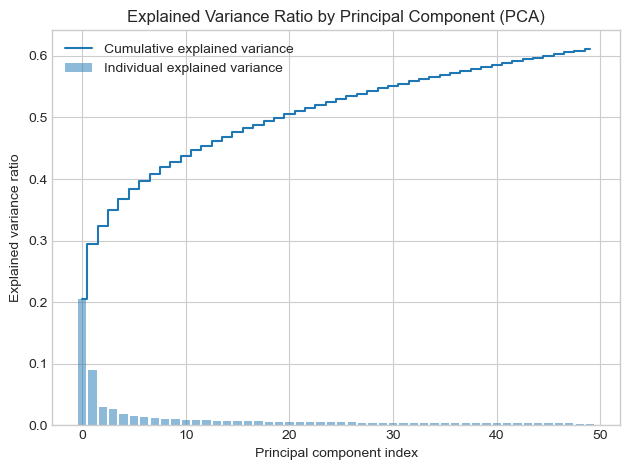

In [29]:
# Sklearn PCA class for determining Explained Variance: https://vitalflux.com/pca-explained-variance-concept-python-example/#:~:text=determining%20explained%20variance-,Sklearn%20PCA%20Class%20for%20determining%20Explained%20Variance,-In%20this%20section
# 
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = aim_pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca[0:50])), exp_var_pca[0:50], alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues[0:50])), cum_sum_eigenvalues[0:50], where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title("Explained Variance Ratio by Principal Component (PCA)")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

As shown in the plot above, the cumulative explained variance only increases by small amounts when 

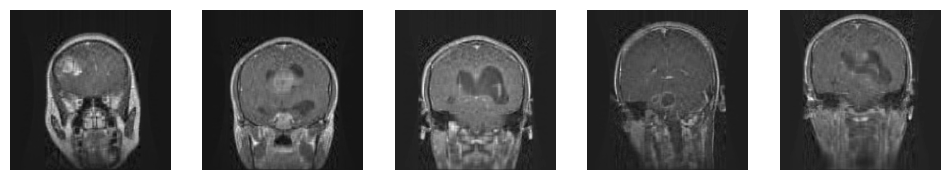

In [13]:
# Perform Image Reconstruction using PCA
# -> 1.5 minutes to run
import numpy as np
from sklearn.decomposition import IncrementalPCA
import matplotlib.pyplot as plt

# Assuming trainPaths is a 2D array where each row represents an image
# and each column represents a pixel in that image.

# Set the number of principal components you want to retain
n_components = 20

# Create an empty array to store the reconstructed images
reconstructed_images = np.zeros_like(trainPaths)

# Initialize IncrementalPCA (used when data is huge)
ipca = IncrementalPCA(n_components=n_components, batch_size=100)  # Adjust batch_size as needed

# Iterate through each image in trainPaths
for i in range(trainPaths.shape[0]):
    image = trainPaths[i, :].reshape(256, 256)  # Assuming each image is 256x256 pixels
    
    # Apply PCA to the current image
    transformed_image = ipca.fit_transform(image)
    
    # Reconstruct the image
    reconstructed_image = ipca.inverse_transform(transformed_image)
    
    # Store the reconstructed image
    reconstructed_images[i, :] = reconstructed_image.ravel()

# Plot some of the reconstructed images
num_images_to_plot = 5
plt.figure(figsize=(12, 8))

for i in range(num_images_to_plot):
    plt.subplot(1, num_images_to_plot, i + 1)
    plt.imshow(reconstructed_images[i, :].reshape(256, 256), cmap=plt.cm.gray)
    plt.axis('off')

plt.title("First 5 images reconstructed using PCA with 20 principal components")
plt.show()


In [82]:
# Explain your analysis and conclusion

[.5 points] Perform linear dimensionality reduction of your image data using randomized principle components analysis. Visualize the explained variance of each component. Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion.

In [32]:
# Get cumulative variance
from sklearn.decomposition import PCA
aim_rpca = PCA(svd_solver="randomized") # takes 15 minutes
aim_rpca.fit(trainPaths)
var_cumu_rpca = np.cumsum(aim_rpca.explained_variance_ratio_)*100


Number of components explaining 95% variance: 1054
Number of components explaining 85% variance (shown): 322
Number of components explaining 70% variance: 97
Number of components explaining 50% variance (shown): 20


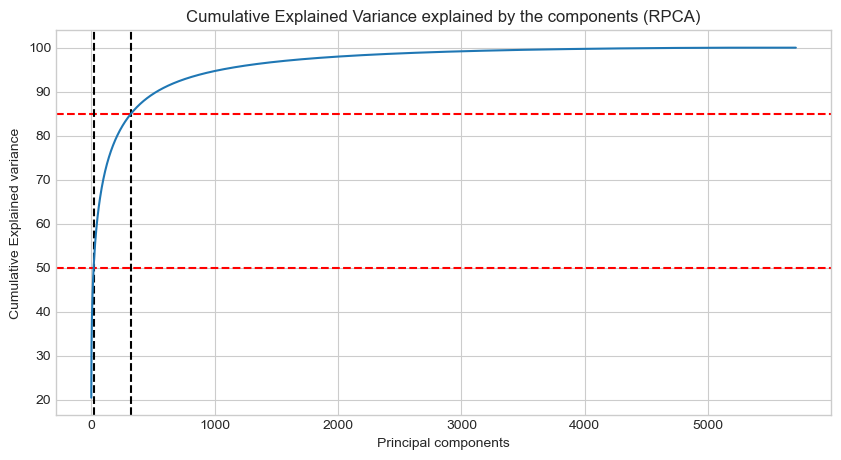

In [33]:
 # how many components explain 95% of the variance?
k95_rpca = np.argmax(var_cumu_rpca > 95)
print("Number of components explaining 95% variance: "+ str(k95_rpca))

# how many components explain 85% of the variance?
k85_rpca = np.argmax(var_cumu_rpca > 85)
print("Number of components explaining 85% variance (shown): "+ str(k85_rpca))

# how many components explain 70% of the variance?
k70_rpca = np.argmax(var_cumu_rpca > 70)
print("Number of components explaining 70% variance: "+ str(k70_rpca))

# how many components explain 50% of the variance?
k50_rpca = np.argmax(var_cumu_rpca > 50)
print("Number of components explaining 50% variance (shown): "+ str(k50_rpca))

plt.figure(figsize=[10,5])
plt.title('Cumulative Explained Variance explained by the components (RPCA)')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axvline(x=k85_rpca, color="k", linestyle="--")
plt.axhline(y=85, color="r", linestyle="--")
plt.axvline(x=k50_rpca, color="k", linestyle="--")
plt.axhline(y=50, color="r", linestyle="--")
ax = plt.plot(var_cumu_rpca)

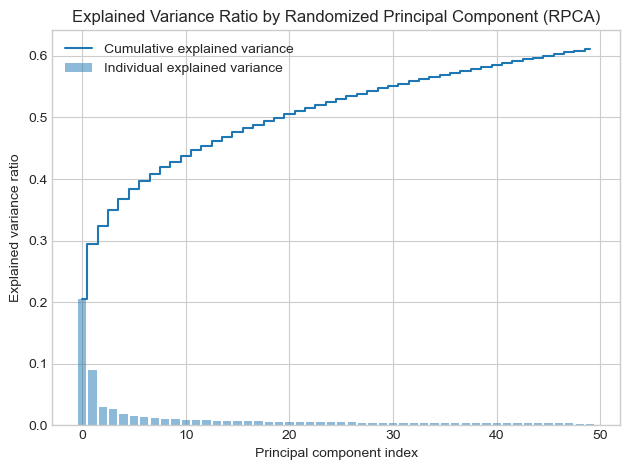

In [34]:
# Sklearn PCA class for determining Explained Variance: https://vitalflux.com/pca-explained-variance-concept-python-example/#:~:text=determining%20explained%20variance-,Sklearn%20PCA%20Class%20for%20determining%20Explained%20Variance,-In%20this%20section
# 
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_rpca = aim_rpca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues_rpca = np.cumsum(exp_var_rpca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_rpca[0:50])), exp_var_rpca[0:50], alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues_rpca[0:50])), cum_sum_eigenvalues_rpca[0:50], where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title("Explained Variance Ratio by Randomized Principal Component (RPCA)")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

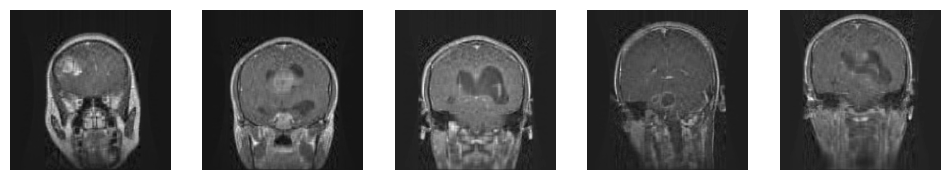

In [35]:
# Perform Image Reconstruction using PCA
# -> 1.5 minutes to run
import numpy as np
from sklearn.decomposition import IncrementalPCA
import matplotlib.pyplot as plt

# Assuming trainPaths is a 2D array where each row represents an image
# and each column represents a pixel in that image.

# Set the number of principal components you want to retain
n_components = 20

# Create an empty array to store the reconstructed images
reconstructed_images = np.zeros_like(trainPaths)

# Initialize IncrementalPCA (used when data is huge)
ipca = IncrementalPCA(n_components=n_components, batch_size=100)  # Adjust batch_size as needed

# Iterate through each image in trainPaths
for i in range(trainPaths.shape[0]):
    image = trainPaths[i, :].reshape(256, 256)  # Assuming each image is 256x256 pixels
    
    # Apply PCA to the current image
    transformed_image = ipca.fit_transform(image)
    
    # Reconstruct the image
    reconstructed_image = ipca.inverse_transform(transformed_image)
    
    # Store the reconstructed image
    reconstructed_images[i, :] = reconstructed_image.ravel()

# Plot some of the reconstructed images
num_images_to_plot = 5
plt.figure(figsize=(12, 8))

for i in range(num_images_to_plot):
    plt.subplot(1, num_images_to_plot, i + 1)
    plt.imshow(reconstructed_images[i, :].reshape(256, 256), cmap=plt.cm.gray)
    plt.axis('off')

plt.show()


[2 points]  Compare the representation using PCA and Randomized PCA. The method you choose to compare dimensionality methods should quantitatively explain which method is better at representing the images with fewer components.  Do you prefer one method over another? Why?

In [ ]:
# Compare PCA and RPCA

# OLD PROJECT CODE - NOT USED (WILL REMOVE LATER)

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Print Version
print("Pandas:", pd.__version__)
print("Numpy:", np.__version__)

# Read CSV File (Load Dataset)
ldData = pd.read_csv('Dataset/Loan_Default.csv')

# Make Sure Data > 1K Rows
print("Shape:", ldData.shape)

# Print Head (5 Rows)
ldData.head()

In [243]:
print(ldData)

            ID  year loan_limit             Gender approv_in_adv loan_type  \
0        24890  2019         cf  Sex Not Available         nopre     type1   
1        24891  2019         cf               Male         nopre     type2   
2        24892  2019         cf               Male           pre     type1   
3        24893  2019         cf               Male         nopre     type1   
4        24894  2019         cf              Joint           pre     type1   
...        ...   ...        ...                ...           ...       ...   
148665  173555  2019         cf  Sex Not Available         nopre     type1   
148666  173556  2019         cf               Male         nopre     type1   
148667  173557  2019         cf               Male         nopre     type1   
148668  173558  2019         cf             Female         nopre     type1   
148669  173559  2019         cf             Female         nopre     type1   

       loan_purpose Credit_Worthiness open_credit business_or_c

In [244]:
# ID Incremental, Year Stagnant - Remove
ldData.drop(['ID', 'year'], axis = 1, inplace = True)

In [245]:
# Print Unique Values For Each Column
for col in ldData[ldData.nunique()[ldData.nunique() < 10].keys()]:
    print(col, ":", ldData[col].unique())

loan_limit : ['cf' nan 'ncf']
Gender : ['Sex Not Available' 'Male' 'Joint' 'Female']
approv_in_adv : ['nopre' 'pre' nan]
loan_type : ['type1' 'type2' 'type3']
loan_purpose : ['p1' 'p4' 'p3' 'p2' nan]
Credit_Worthiness : ['l1' 'l2']
open_credit : ['nopc' 'opc']
business_or_commercial : ['nob/c' 'b/c']
Neg_ammortization : ['not_neg' 'neg_amm' nan]
interest_only : ['not_int' 'int_only']
lump_sum_payment : ['not_lpsm' 'lpsm']
construction_type : ['sb' 'mh']
occupancy_type : ['pr' 'sr' 'ir']
Secured_by : ['home' 'land']
total_units : ['1U' '2U' '3U' '4U']
credit_type : ['EXP' 'EQUI' 'CRIF' 'CIB']
co-applicant_credit_type : ['CIB' 'EXP']
age : ['25-34' '55-64' '35-44' '45-54' '65-74' '>74' '<25' nan]
submission_of_application : ['to_inst' 'not_inst' nan]
Region : ['south' 'North' 'central' 'North-East']
Security_Type : ['direct' 'Indriect']
Status : [1 0]


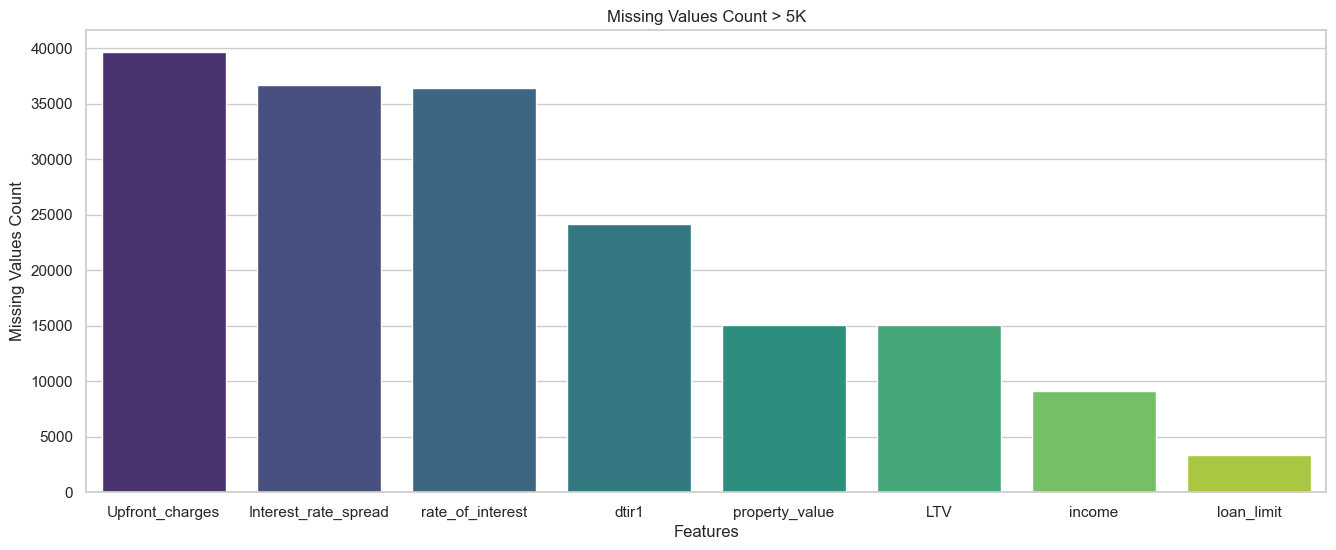

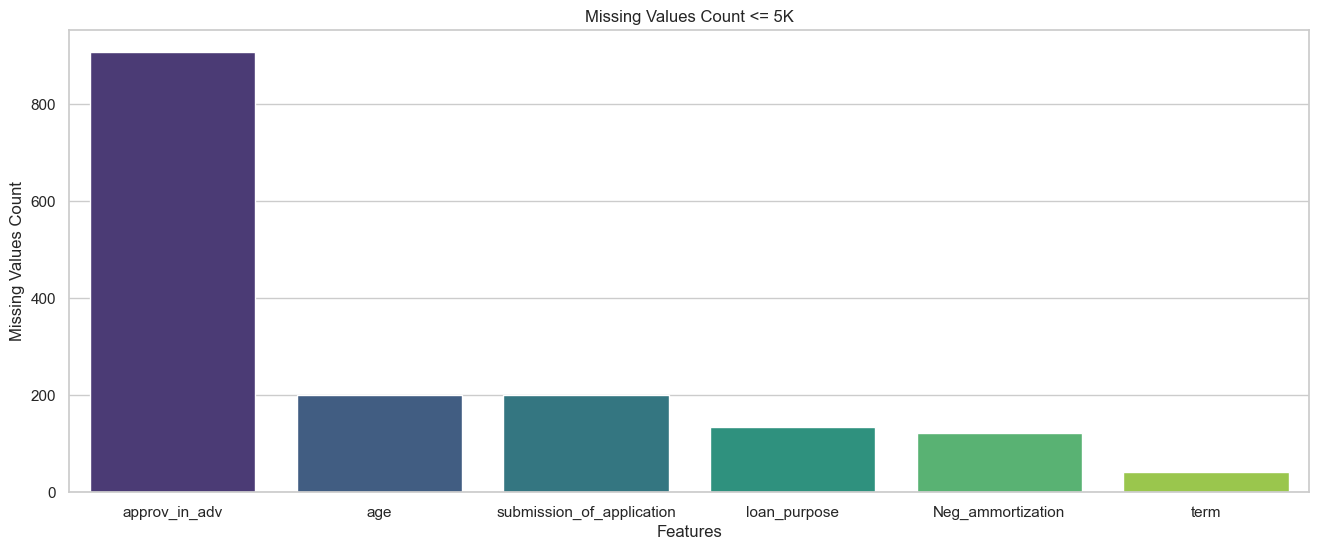

In [246]:
# Find Missing Values (Sort)
missCount = ldData.isnull().sum()[ldData.isnull().sum() > 0]
missCountGT5k = missCount[missCount > 3000].sort_values(ascending = False)
missCountLT5k = missCount[missCount <= 3000].sort_values(ascending = False)

# Create Seaborn Bar Plot GT3k
sns.set(style = "whitegrid")
plt.figure(figsize = (16, 6))
sns.barplot(x = missCountGT5k.index, y = missCountGT5k.values, palette = "viridis")
plt.title('Missing Values Count > 5K')
plt.xlabel('Features')
plt.ylabel('Missing Values Count')
plt.show()

# Create Seaborn Bar Plot LT3k
sns.set(style = "whitegrid")
plt.figure(figsize = (16, 6))
sns.barplot(x = missCountLT5k.index, y = missCountLT5k.values, palette = "viridis")
plt.title('Missing Values Count <= 5K')
plt.xlabel('Features')
plt.ylabel('Missing Values Count')
plt.show()

In [247]:
# Impute NA Values With Zero (Reasonable Assumption)
ldData['Upfront_charges'].fillna(0, inplace = True)
ldData['income'].fillna(0, inplace = True)

# Remove Interest Rate Spread, Rate Of Interest - Too Many Rows!
ldData.drop(['Interest_rate_spread', 'rate_of_interest'], axis = 1, inplace = True)

# Drop NA Values (Few Columns, Little Change In Shape)
ldData.dropna(subset = ['loan_limit', 'approv_in_adv', 'age', 'submission_of_application', 'loan_purpose', 'Neg_ammortization', 'term'], inplace = True)

# Print Shape
print(ldData.shape)

(143942, 30)


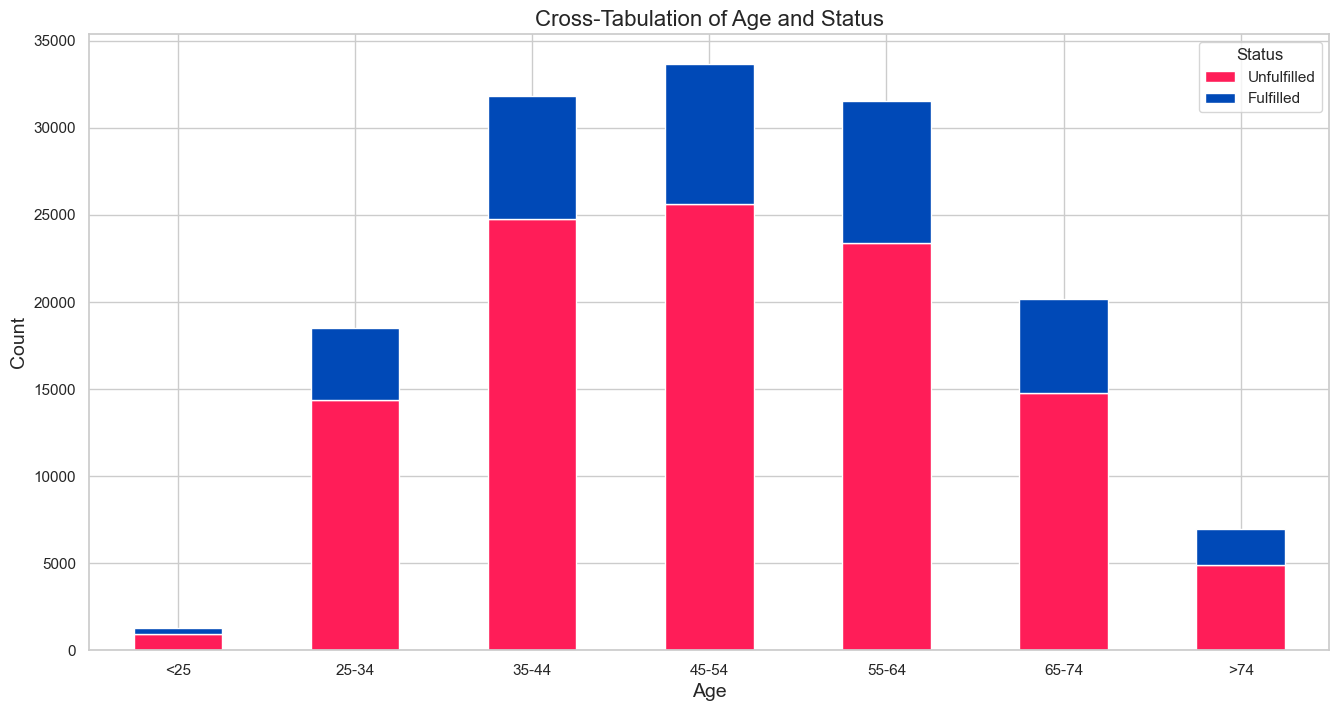

In [248]:
# Create Cross-Tabulation Of Age, Status
ldDataCrossTab = pd.crosstab(ldData['age'], ldData['Status'])

# Order By List Of Values In Age Column
ldDataCrossTab = ldDataCrossTab.reindex(sorted(ldDataCrossTab.columns), axis = 1)

# Move Unsorted Row To Top
ldDataCrossTab = ldDataCrossTab.reindex(['<25'] + list(ldDataCrossTab.index.drop('<25')), axis = 0)

# Create The Plot
ldDataCrossTab.plot(kind = 'bar', stacked = True, figsize = (16, 8), color = ['#FF1D58', '#0049B7'])

# Add Labels, Fix Rotation, Add Legend
plt.title('Cross-Tabulation of Age and Status', fontsize = 16)
plt.xlabel('Age', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.xticks(rotation = 0)
plt.legend(title = 'Status', labels = ('Unfulfilled', 'Fulfilled'))

# Show Plot
plt.show()

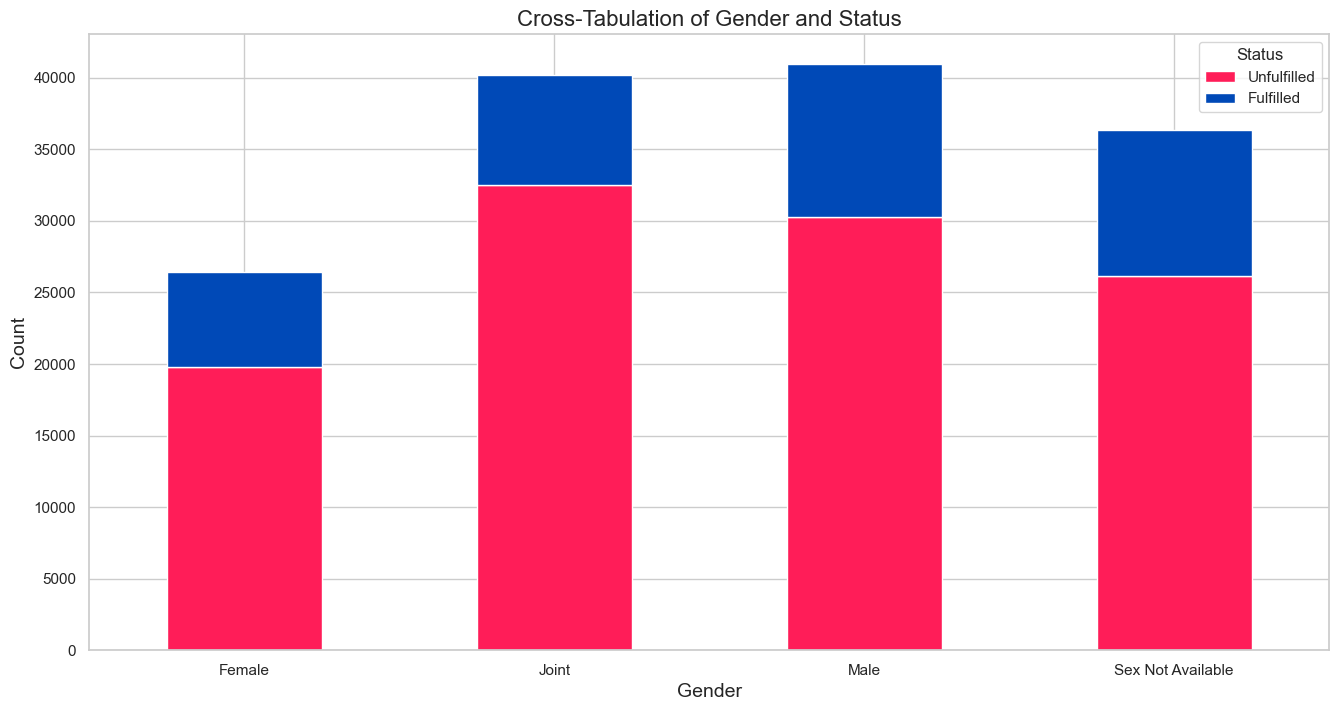

In [249]:
# Create Cross Tabulation Of Gender, Status
ldDataCrossTab = pd.crosstab(ldData['Gender'], ldData['Status'])

# Create The Plot
ldDataCrossTab.plot(kind = 'bar', stacked = True, figsize = (16, 8), color = ['#FF1D58', '#0049B7'])

# Add Labels, Fix Rotation, Add Legend
plt.title('Cross-Tabulation of Gender and Status', fontsize = 16)
plt.xlabel('Gender', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.xticks(rotation = 0)
plt.legend(title = 'Status', labels = ('Unfulfilled', 'Fulfilled'))

# Show Plot
plt.show()


# LTV, Property Value, Loan Amount

In [250]:
# Find Columns with Missing Remaining Values
ldData.isnull().sum()[ldData.isnull().sum() > 0].sort_values(ascending = False)

dtir1             23305
property_value    14597
LTV               14597
dtype: int64

In [251]:
# Would Be Hard To Impute Missing Values For Debt To Income Ratio
ldData.drop(['dtir1'], axis = 1, inplace = True)

In [252]:
# Replace Missing Property Value With Column Median
ldData['property_value'].fillna(ldData['property_value'].median(), inplace = True)

# Calculate Missing LTV Values From Loan Amount / Property Value (Formula)
ldData['LTV'].fillna(ldData['loan_amount'] / ldData['property_value'], inplace = True)

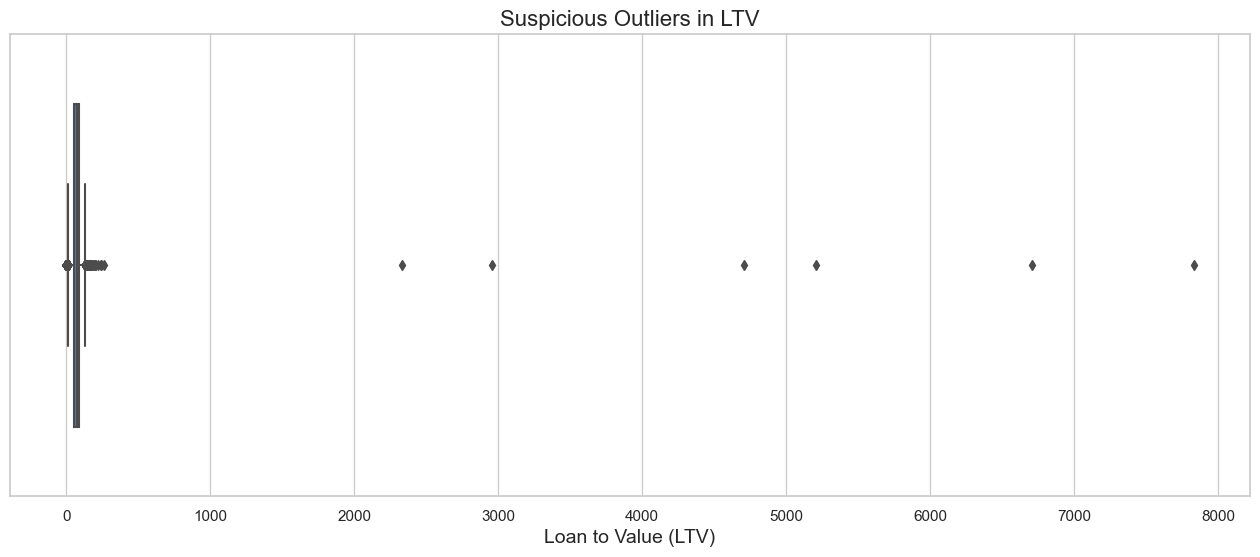

In [255]:
# Plot LTV Values
sns.set_style("whitegrid")
plt.figure(figsize = (16, 6))
sns.boxplot(x = "LTV", data = ldData, width = 0.7)
plt.title("Suspicious Outliers in LTV", fontsize = 16)
plt.xlabel("Loan to Value (LTV)", fontsize = 14)
plt.show()

In [256]:
# LTV (Loan-Value) Ratio = Percentage (Should Ideally Be In [0, 1])
# LTV = Loan Amount / Property Value
# If Loan Amount > Property Value, LTV > 1
# These Account For Suspicious Outliers (Property Value == 8000 => Most Likely Initially Missing Value)
ldData[['property_value', 'loan_amount', 'LTV']][ldData.LTV > 1000]

,property_value,loan_amount,LTV
16951,8000.0,626500,7831.25
46287,8000.0,236500,2956.25
47807,8000.0,416500,5206.25
55286,8000.0,536500,6706.25
65238,8000.0,376500,4706.25
123343,8000.0,186500,2331.25


In [257]:
# Drop Suspicious Columns Above
ldData = ldData[ldData.property_value != 8000]

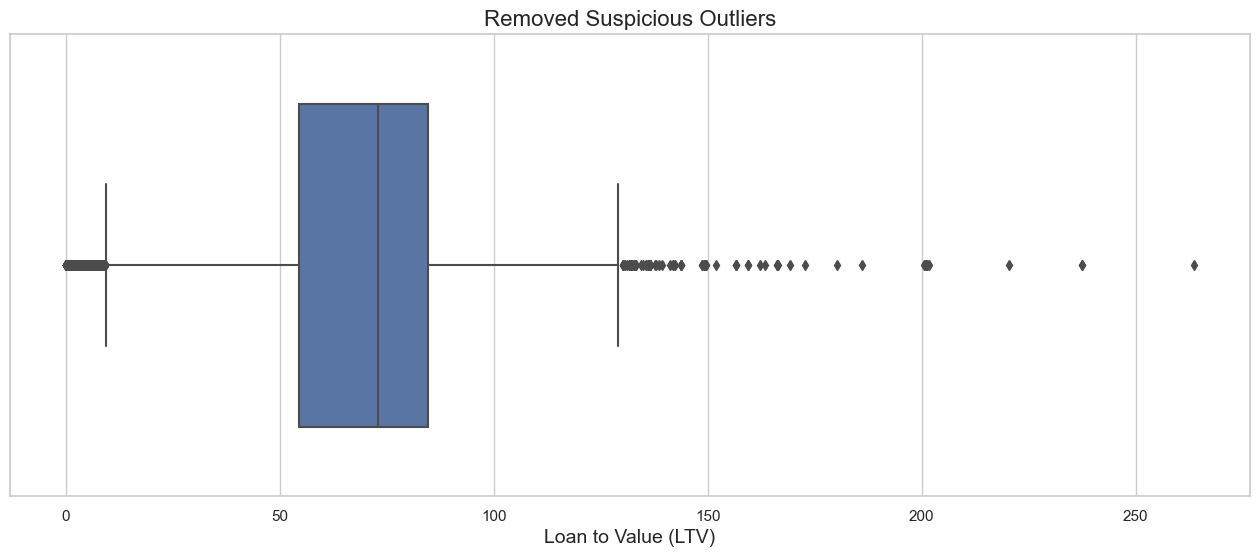

In [258]:
# Plot LTV Values
sns.set_style("whitegrid")
plt.figure(figsize = (16, 6))
sns.boxplot(x = "LTV", data = ldData, width = 0.7)
plt.title("Removed Suspicious Outliers", fontsize = 16)
plt.xlabel("Loan to Value (LTV)", fontsize = 14)
plt.show()

# Given that the probability of getting an LTV ratio more than 100% is low 
# (for non fulfilled cases), even if it represents a high-risk authorization, 
# it would be advisable for the loan lender to keep offering this kind of service

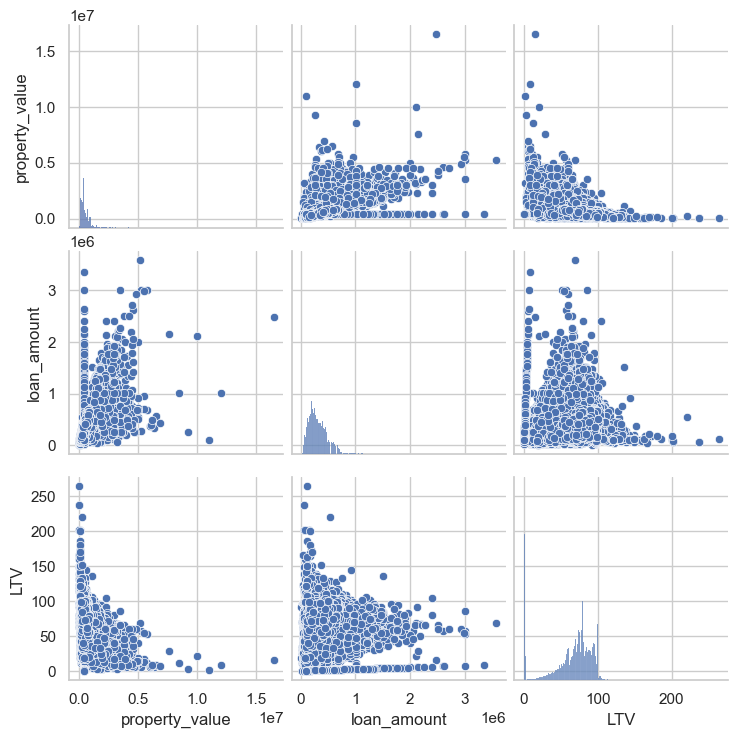

In [259]:
# Make Pairwise Plot
sns.pairplot(ldData[["property_value", "loan_amount", "LTV"]])
plt.show()

# Note Correlation Between Property Value And Loan Amount (Linear Relationship)
# Note Inverse Exponential Relationship Between LTV And Property Value (Non-Linear Relationship)

# Float Analysis, UMAP, PCA

In [187]:
from sklearn.preprocessing import StandardScaler

# Get Float Columns From Dataframe
ldDataFloat = ldData.select_dtypes(include = ['float64']).values
scaledFloatData = StandardScaler().fit_transform(ldDataFloat)

In [208]:
# 3 / 4 Loan Default
print(ldData[ldData['Status'] == 0].shape[0])
print(ldData[ldData['Status'] == 1].shape[0])

108682
35254


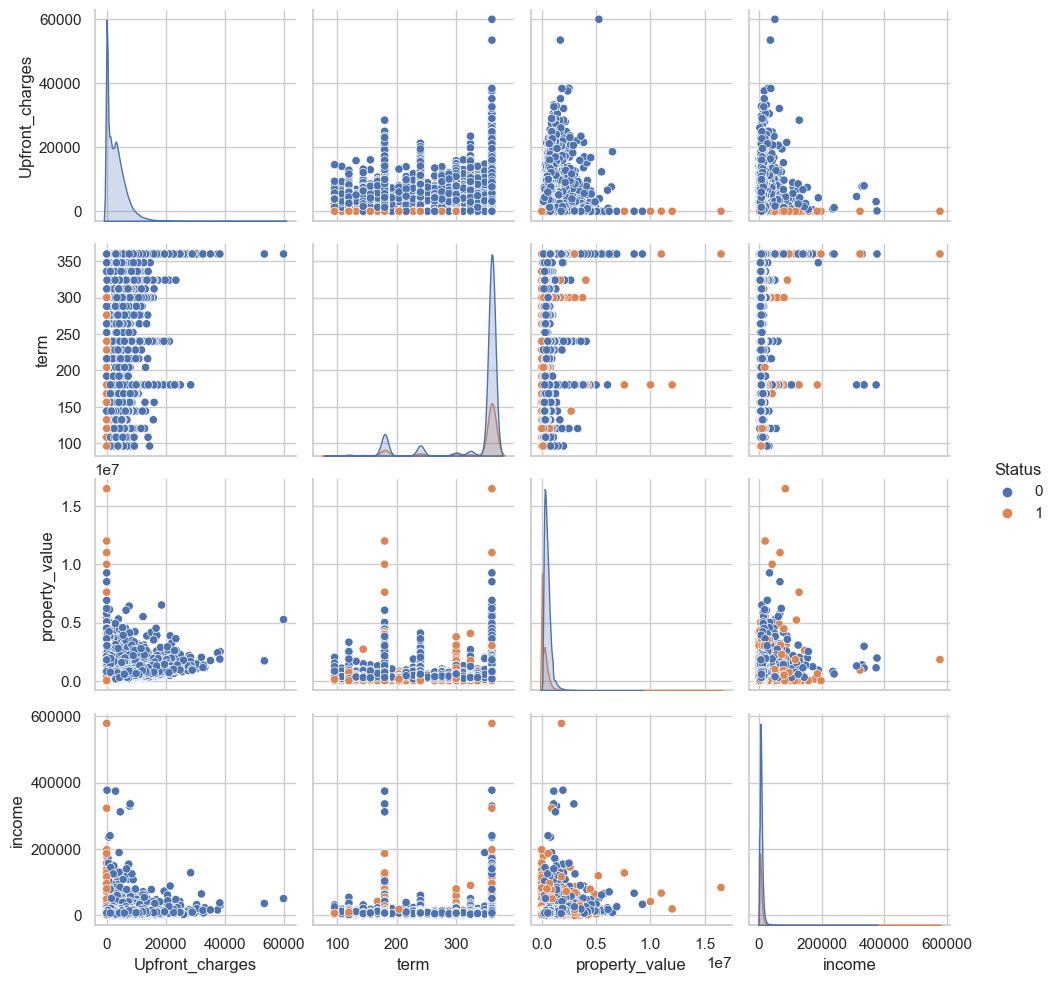

In [205]:
# Plot Float Values With Status Hue
sns.pairplot(ldData[["Upfront_charges", "term", "property_value", "income", "Status"]], hue = "Status")
plt.show()

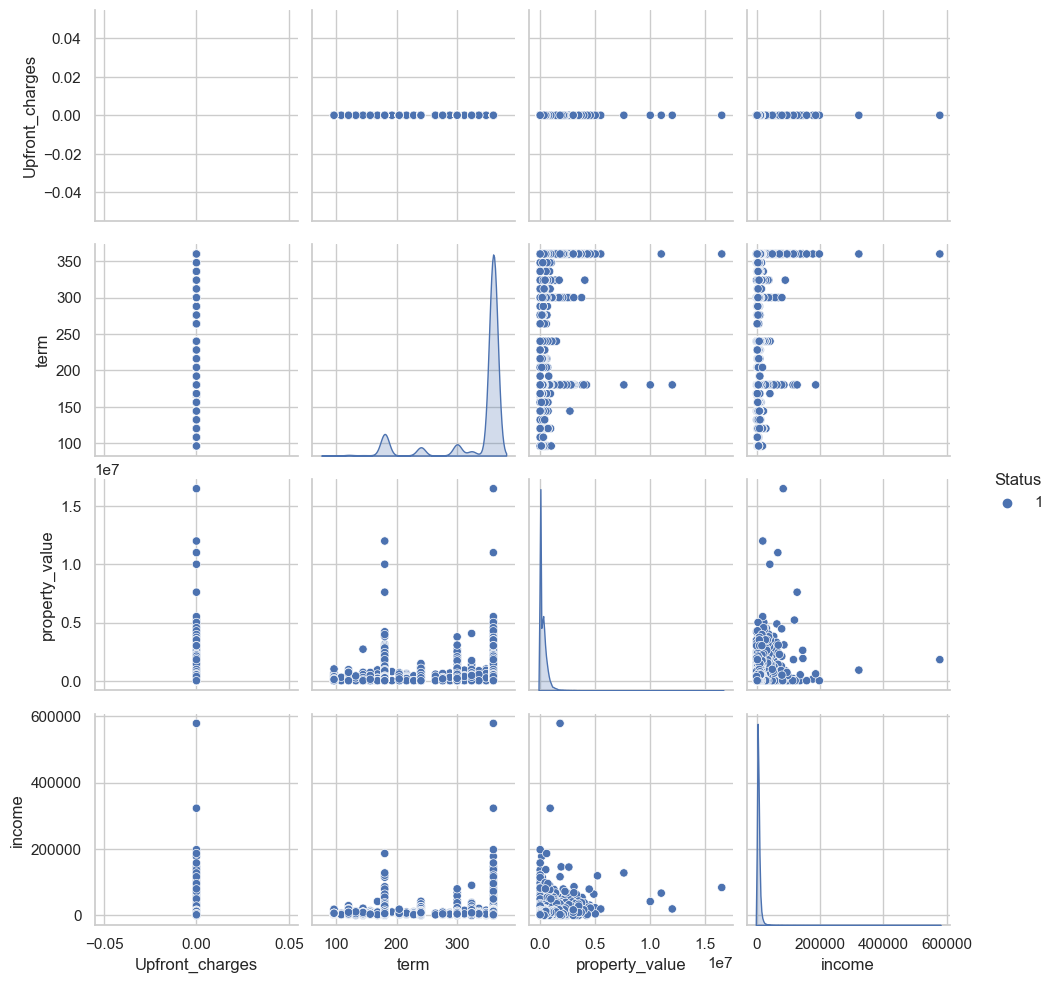

In [213]:
# Look Specifically At Loan Default Status == 1 (Defaulted)
sns.pairplot(ldData[ldData['Status'] == 1][["Upfront_charges", "term", "property_value", "income", "Status"]], hue = "Status")
plt.show()

# This Plot Shows That Whenever The Loan Defaulted, The Upfront Charges Were 0.0

# Exceptional Work

In [188]:
# Create Mapper
dataMapper = umap.UMAP().fit(scaledFloatData)

c:\Users\trevo\anaconda3\envs\classes\lib\site-packages\umap\plot.py:203: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


<Axes: >

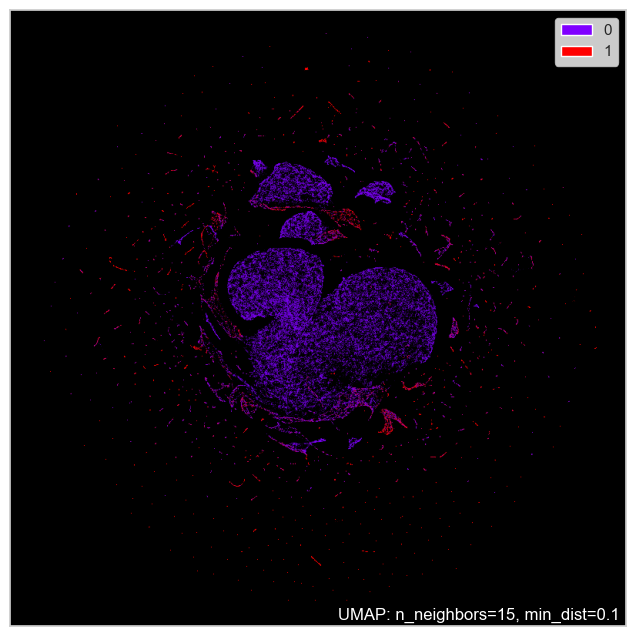

In [190]:
# Cluster Plot
umap.plot.points(dataMapper, labels = ldData['Status'], theme = 'fire')

<Axes: >

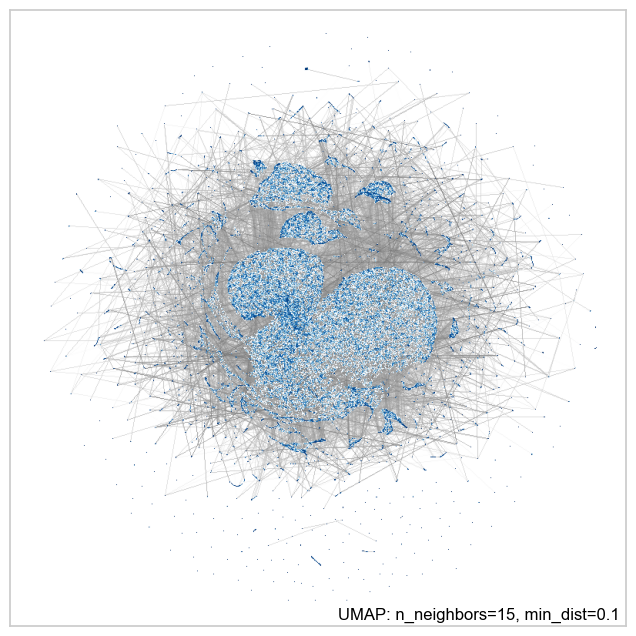

In [191]:
# UMAP Connectivity Graph
umap.plot.connectivity(dataMapper, show_points = True)

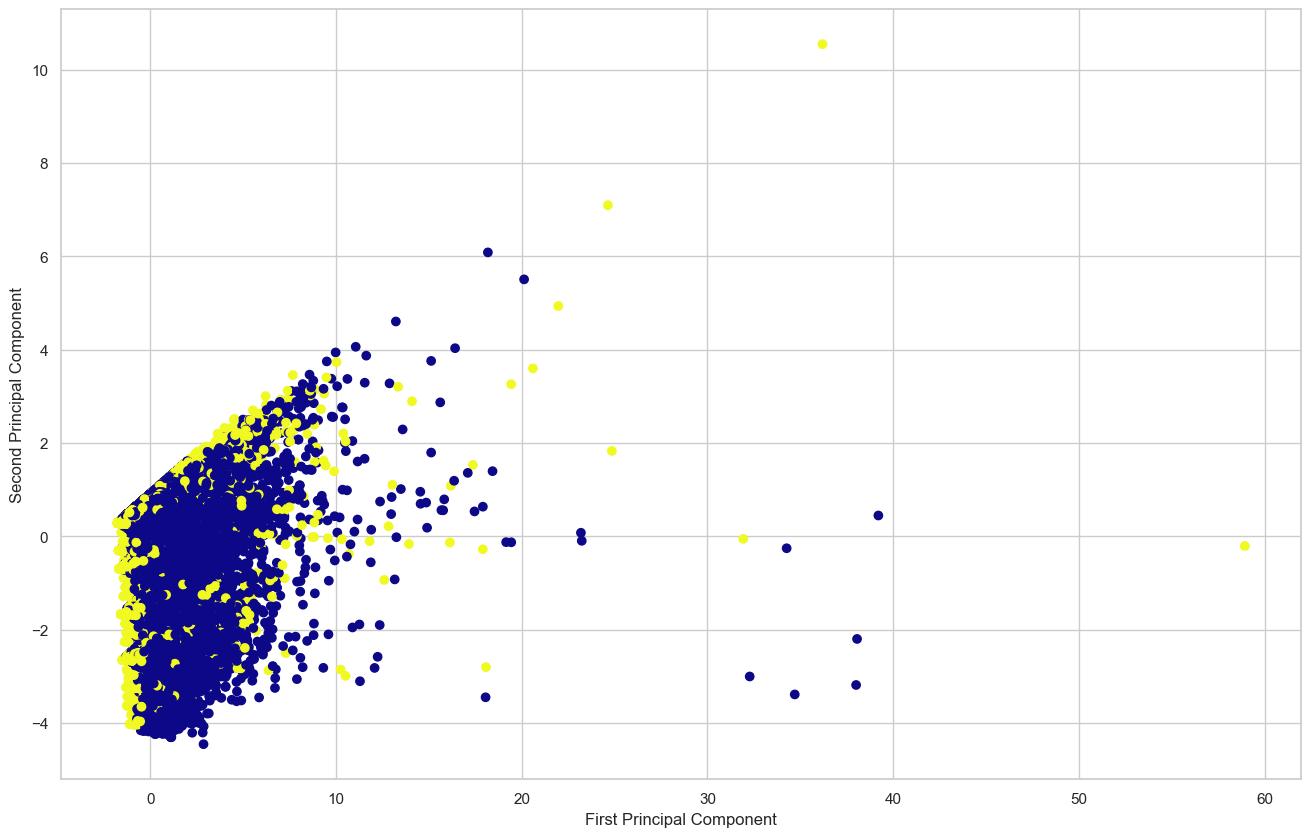

In [217]:
# Let's Check Out PCA
from sklearn.decomposition import PCA

# Fit PCA
pca = PCA(n_components = 2)
pca.fit(scaledFloatData)
pcaData = pca.transform(scaledFloatData)

# Plot PCA Data
plt.figure(figsize = (16, 10))
plt.scatter(pcaData[:, 0], pcaData[:, 1], c = ldData['Status'], cmap = 'plasma')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

# As We Can See, PCA Is Not Good Here (But It's Fast!)

UMAP (Uniform Manifold Approximation and Projection) and PCA (Principal Component Analysis) are both dimensionality reduction techniques used to visualize multi-dimensional data in a 2D space. UMAP is a newer, non-linear method that preserves more of the global structure of the data, while PCA is a linear method that is faster and more widely used. In this section, we will compare these two methods which have already been visualized above.

UMAP, a neighbor graph method, is based on the concept of the uniform topological manifold, a space that is locally flat. It uses the Nerve Theorem to construct a fuzzy simplicial complex from the data (approximating the uniform manifold), which is then used to create a low-dimensional embedding of the data (projection). Note that, by definition of the Riemann manifold, we are able to homotopically reduce the dimension of the manifold. Algebraically, this process involves calculating edge similarities between nodes, initializing a low-dimensional graph, and optimizing a cross-entropy loss function to clearly define clusters in the low-dimensional space. The fuzzy union operation, defined as $ \alpha + \beta - \alpha \cdot \beta $, is crucial in this process.

On the other hand, PCA, a matrix factorization method, works by identifying the axes in the data that explain the most variance (Covariance matrix), and projecting the data onto these axes (Eigendecomposition). This linear method is faster than UMAP, but it may not capture non-linear relationships between the data as effectively, and thus does much worse on the task than UMAP, which we can see visually.

Comparing the two, UMAP tends to produce more defined clusters than PCA, due to its ability to capture non-linear relationships. However, PCA is significantly faster, making it a more practical choice for large datasets or quick analyses. 

References: 
- [Understanding UMAP](https://pair-code.github.io/understanding-umap/)
- [UMAP Supplement](https://pair-code.github.io/understanding-umap/supplement.html)
- [UMAP GitHub](https://github.com/lmcinnes/umap)
- [UMAP Documentation](https://umap-learn.readthedocs.io/en/latest/basic_usage.html)
- [UMAP Paper](https://arxiv.org/pdf/1802.03426.pdf)
- [UMAP YouTube Video 1](https://www.youtube.com/watch?v=eN0wFzBA4Sc)
- [UMAP YouTube Video 2](https://www.youtube.com/watch?v=jth4kEvJ3P8&t)
- [UMAP YouTube Video 3](https://www.youtube.com/watch?v=nq6iPZVUxZU)